# Machine learning case studies HW 1
## Time series

### Imports

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from lightgbm import LGBMRegressor

### Data reading

In [26]:
csv_path = '../data/DataSet_Tesco5000_withDaynum.csv'
df = pd.read_csv(csv_path)
df.head()

,customer_id,visit_date,visit_spend,daynum
0,2,2010-04-01,5.97,0
1,2,2010-04-06,12.71,5
2,2,2010-04-07,34.52,6
3,2,2010-04-12,7.89,11
4,2,2010-04-14,17.17,13


In [27]:
df['visit_date'] = pd.to_datetime(df['visit_date'], format='%Y-%m-%d')

In [28]:
print(df.dtypes)
print(df.info)
df.head()

customer_id             int64
visit_date     datetime64[ns]
visit_spend           float64
daynum                  int64
dtype: object
<bound method DataFrame.info of         customer_id visit_date  visit_spend  daynum
0                 2 2010-04-01         5.97       0
1                 2 2010-04-06        12.71       5
2                 2 2010-04-07        34.52       6
3                 2 2010-04-12         7.89      11
4                 2 2010-04-14        17.17      13
...             ...        ...          ...     ...
596728         7376 2011-05-15         4.86     409
596729         7376 2011-05-24        56.55     418
596730         7376 2011-05-26        60.25     420
596731         7376 2011-06-09       159.15     434
596732         7376 2011-06-19         5.98     444

[596733 rows x 4 columns]>


,customer_id,visit_date,visit_spend,daynum
0,2,2010-04-01,5.97,0
1,2,2010-04-06,12.71,5
2,2,2010-04-07,34.52,6
3,2,2010-04-12,7.89,11
4,2,2010-04-14,17.17,13


In [29]:
daily_revenue = (
    df.groupby('visit_date')['visit_spend']
    .sum()
    .reset_index()
    .sort_values("visit_date")
)

In [30]:
daily_revenue.columns = ["date", "revenue"]
daily_revenue

,date,revenue
0,2010-04-01,102625.86
1,2010-04-02,82660.90
2,2010-04-03,78081.71
3,2010-04-04,4411.05
4,2010-04-05,38144.77
...,...,...
439,2011-06-15,51252.38
440,2011-06-16,68920.34
441,2011-06-17,80762.94
442,2011-06-18,81009.66


In [31]:
colors = ["#a11462", "#137547", "#452eaa"]

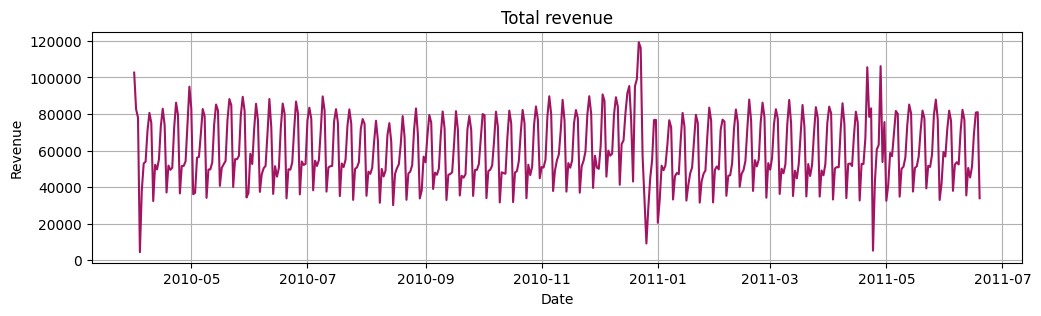

In [32]:
plt.figure(figsize=(12,3))
plt.plot(daily_revenue["date"], daily_revenue["revenue"], color=colors[0])
plt.title("Total revenue")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()

In [33]:
daily_revenue["day_of_week"] = daily_revenue["date"].dt.dayofweek
daily_revenue["month"] = daily_revenue["date"].dt.month
daily_revenue["year"] = daily_revenue["date"].dt.year

In [34]:
daily_revenue.tail()

,date,revenue,day_of_week,month,year
439,2011-06-15,51252.38,2,6,2011
440,2011-06-16,68920.34,3,6,2011
441,2011-06-17,80762.94,4,6,2011
442,2011-06-18,81009.66,5,6,2011
443,2011-06-19,33933.16,6,6,2011


### Baseline

In [35]:
daily_revenue["baseline_pred"] = daily_revenue["revenue"].shift(14)
daily_revenue.head(16)

,date,revenue,day_of_week,month,year,baseline_pred
0,2010-04-01,102625.86,3,4,2010,NaN
1,2010-04-02,82660.90,4,4,2010,NaN
2,2010-04-03,78081.71,5,4,2010,NaN
3,2010-04-04,4411.05,6,4,2010,NaN
4,2010-04-05,38144.77,0,4,2010,NaN
5,2010-04-06,52928.27,1,4,2010,NaN
6,2010-04-07,53908.71,2,4,2010,NaN
7,2010-04-08,70863.75,3,4,2010,NaN
8,2010-04-09,80590.71,4,4,2010,NaN
9,2010-04-10,75106.49,5,4,2010,NaN


In [36]:
last_day = daily_revenue["date"].max()
print(last_day.date())

2011-06-19


In [37]:
eval_start = last_day - pd.Timedelta(days=89)
eval_end = last_day
print("Evaluation period:", eval_start.date(), "to", eval_end.date())

Evaluation period: 2011-03-22 to 2011-06-19


In [38]:
fridays = daily_revenue[
    (daily_revenue["date"] >= eval_start) &
    (daily_revenue["date"] <= eval_end) &
    (daily_revenue["date"].dt.dayofweek == 4)
]["date"].to_list()


In [39]:
print(fridays)

[Timestamp('2011-03-25 00:00:00'), Timestamp('2011-04-01 00:00:00'), Timestamp('2011-04-08 00:00:00'), Timestamp('2011-04-15 00:00:00'), Timestamp('2011-04-22 00:00:00'), Timestamp('2011-04-29 00:00:00'), Timestamp('2011-05-06 00:00:00'), Timestamp('2011-05-13 00:00:00'), Timestamp('2011-05-20 00:00:00'), Timestamp('2011-05-27 00:00:00'), Timestamp('2011-06-03 00:00:00'), Timestamp('2011-06-10 00:00:00'), Timestamp('2011-06-17 00:00:00')]


In [40]:

predictions = []
for friday in fridays: 
    forecast_days = pd.date_range(friday, friday + pd.Timedelta(days=6), freq='D') # forecast for 7 days
    # print("Forecast period:", forecast_days[0].date(), "to", forecast_days[-1].date())
    
    for day in forecast_days:
        
        ref_day = day - pd.Timedelta(days=14)
        
        if ref_day in daily_revenue["date"].values:
            y_hat = daily_revenue.loc[daily_revenue["date"] == ref_day, "revenue"].values[0]
        else:
            y_hat = None  # No prediction at the beggining
    
        if day in daily_revenue["date"].values:
            y_true = daily_revenue.loc[daily_revenue["date"] == day, "revenue"].values[0]
        else:
            y_true = None  # No true value at the future
    
        predictions.append({
            "date": friday,
            "target_date": day,
            "y_true": y_true,
            "y_pred_bl": y_hat
        })

In [41]:
baseline_preds = pd.DataFrame(predictions)

baseline_preds = baseline_preds[
    (baseline_preds["target_date"] >= eval_start) &
    (baseline_preds["target_date"] <= eval_end)
].reset_index(drop=True)

print(baseline_preds.__len__()) # should be less than 90 days?

87


In [42]:
eval_df = baseline_preds.dropna(subset=["y_true", "y_pred_bl"])

y_true = eval_df["y_true"].values
y_pred = eval_df["y_pred_bl"].values

baseline_mae = mean_absolute_error(y_true, y_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
baseline_smape = 100 * np.mean(
    2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
)

print(f"Baseline  MAE  = {baseline_mae:.2f}")
print(f"Baseline  RMSE = {baseline_rmse:.2f}")
print(f"Baseline  sMAPE = {baseline_smape:.2f}%")


Baseline  MAE  = 6816.97
Baseline  RMSE = 11175.05
Baseline  sMAPE = 13.00%


#### MAE
Approx. 6800 error on each day.
#### RMSE
Approx. 11175 root mean squared error. It's sensitive for large outliers. Probably big sales, holidays etc.
#### sMAPE
Symmetric Mean Absolute Percentage Error. Unit idependet error percentage. Approx. 13 % is an acceptable performance.

### Prophet model

#### Sources
- Prophet official website: [link](https://facebook.github.io/prophet/)
- Prophet Medium: [link](https://medium.com/data-science/getting-started-predicting-time-series-data-with-facebook-prophet-c74ad3040525)

In [43]:
prophet_daily_revenue = daily_revenue[["date", "revenue"]]
prophet_daily_revenue.rename(columns={"date": "ds", "revenue": "y"}, inplace=True)

print(prophet_daily_revenue.head())

          ds          y
0 2010-04-01  102625.86
1 2010-04-02   82660.90
2 2010-04-03   78081.71
3 2010-04-04    4411.05
4 2010-04-05   38144.77


/tmp/ipykernel_10501/92464215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_daily_revenue.rename(columns={"date": "ds", "revenue": "y"}, inplace=True)


In [44]:
start_date = prophet_daily_revenue['ds'].max() - timedelta(days=90)
forecast_horizon = 7
preds = []

In [45]:
for friday in pd.date_range(start_date, prophet_daily_revenue['ds'].max(), freq='W-FRI'):
    train_end = friday - timedelta(days=1)
    train_data = prophet_daily_revenue[prophet_daily_revenue['ds'] <= train_end]
    
    if len(train_data) < 30:
        continue  # Skip if not enough data to train
    
    model = Prophet(weekly_seasonality = True)
    model.fit(train_data)
    
    future = model.make_future_dataframe(periods=forecast_horizon)
    forecast = model.predict(future)
    
    pred_wind = forecast.tail(forecast_horizon)[['ds', 'yhat']]
    pred_wind['train_end'] = train_end
    preds.append(pred_wind)

14:08:54 - cmdstanpy - INFO - Chain [1] start processing
14:08:54 - cmdstanpy - INFO - Chain [1] done processing
14:08:54 - cmdstanpy - INFO - Chain [1] start processing
14:08:54 - cmdstanpy - INFO - Chain [1] done processing
14:08:54 - cmdstanpy - INFO - Chain [1] start processing
14:08:54 - cmdstanpy - INFO - Chain [1] done processing
14:08:54 - cmdstanpy - INFO - Chain [1] start processing
14:08:54 - cmdstanpy - INFO - Chain [1] done processing
14:08:54 - cmdstanpy - INFO - Chain [1] start processing
14:08:54 - cmdstanpy - INFO - Chain [1] done processing
14:08:54 - cmdstanpy - INFO - Chain [1] start processing
14:08:55 - cmdstanpy - INFO - Chain [1] done processing
14:08:55 - cmdstanpy - INFO - Chain [1] start processing
14:08:55 - cmdstanpy - INFO - Chain [1] done processing
14:08:55 - cmdstanpy - INFO - Chain [1] start processing
14:08:55 - cmdstanpy - INFO - Chain [1] done processing
14:08:55 - cmdstanpy - INFO - Chain [1] start processing
14:08:55 - cmdstanpy - INFO - Chain [1]

In [46]:
prophet_predictions = pd.concat(preds)
prophet_predictions = prophet_predictions.merge(prophet_daily_revenue, on="ds", how="left")

In [47]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# mask
eval_mask = ~prophet_predictions['y'].isna()
y_true = prophet_predictions.loc[eval_mask, 'y']
y_pred = prophet_predictions.loc[eval_mask, 'yhat']

prophet_mae = mean_absolute_error(y_true, y_pred)
prophet_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
prophet_smape = smape(y_true, y_pred)

print(f"Prophet MAE  = {prophet_mae:.2f}")
print(f"Prophet RMSE = {prophet_rmse:.2f}")
print(f"Prophet sMAPE = {prophet_smape:.2f}%")

Prophet MAE  = 4224.17
Prophet RMSE = 7764.65
Prophet sMAPE = 7.87%


#### MAE
Approx. 4224 error on each day.
#### RMSE
Approx. 7764 root mean squared error. This metric is quite sensitive for large outliers. Probably big sales, holidays etc.
#### sMAPE
Symmetric Mean Absolute Percentage Error. Unit idependet error percentage. Approx. 7.9 % is a much better performance.

### Machine learning with LightGBM
- LightGBM documentation: [link](https://lightgbm.readthedocs.io/en/stable/)

In [48]:
ml_df = daily_revenue.copy()
ml_df.drop(columns=["baseline_pred"], axis=1, inplace=True)
# ml_df.to_csv('ml_df_initial.csv', index=False)

In [49]:
# defining lags
ml_df["lag_1"] = ml_df["revenue"].shift(1)
ml_df["lag_7"] = ml_df["revenue"].shift(7)
ml_df["lag_14"] = ml_df["revenue"].shift(14)
print(ml_df.head(16))

         date    revenue  day_of_week  month  year      lag_1      lag_7  \
0  2010-04-01  102625.86            3      4  2010        NaN        NaN   
1  2010-04-02   82660.90            4      4  2010  102625.86        NaN   
2  2010-04-03   78081.71            5      4  2010   82660.90        NaN   
3  2010-04-04    4411.05            6      4  2010   78081.71        NaN   
4  2010-04-05   38144.77            0      4  2010    4411.05        NaN   
5  2010-04-06   52928.27            1      4  2010   38144.77        NaN   
6  2010-04-07   53908.71            2      4  2010   52928.27        NaN   
7  2010-04-08   70863.75            3      4  2010   53908.71  102625.86   
8  2010-04-09   80590.71            4      4  2010   70863.75   82660.90   
9  2010-04-10   75106.49            5      4  2010   80590.71   78081.71   
10 2010-04-11   32378.62            6      4  2010   75106.49    4411.05   
11 2010-04-12   52254.00            0      4  2010   32378.62   38144.77   
12 2010-04-1

In [50]:
# moving averages
ml_df["ma_7"] = ml_df["revenue"].shift(1).rolling(window=7).mean()
print(ml_df.head(16))

         date    revenue  day_of_week  month  year      lag_1      lag_7  \
0  2010-04-01  102625.86            3      4  2010        NaN        NaN   
1  2010-04-02   82660.90            4      4  2010  102625.86        NaN   
2  2010-04-03   78081.71            5      4  2010   82660.90        NaN   
3  2010-04-04    4411.05            6      4  2010   78081.71        NaN   
4  2010-04-05   38144.77            0      4  2010    4411.05        NaN   
5  2010-04-06   52928.27            1      4  2010   38144.77        NaN   
6  2010-04-07   53908.71            2      4  2010   52928.27        NaN   
7  2010-04-08   70863.75            3      4  2010   53908.71  102625.86   
8  2010-04-09   80590.71            4      4  2010   70863.75   82660.90   
9  2010-04-10   75106.49            5      4  2010   80590.71   78081.71   
10 2010-04-11   32378.62            6      4  2010   75106.49    4411.05   
11 2010-04-12   52254.00            0      4  2010   32378.62   38144.77   
12 2010-04-1

In [51]:
ml_df["is_weekend"] = ml_df["date"].dt.dayofweek.isin([5, 6]).astype(int)
print(ml_df.head(16))

         date    revenue  day_of_week  month  year      lag_1      lag_7  \
0  2010-04-01  102625.86            3      4  2010        NaN        NaN   
1  2010-04-02   82660.90            4      4  2010  102625.86        NaN   
2  2010-04-03   78081.71            5      4  2010   82660.90        NaN   
3  2010-04-04    4411.05            6      4  2010   78081.71        NaN   
4  2010-04-05   38144.77            0      4  2010    4411.05        NaN   
5  2010-04-06   52928.27            1      4  2010   38144.77        NaN   
6  2010-04-07   53908.71            2      4  2010   52928.27        NaN   
7  2010-04-08   70863.75            3      4  2010   53908.71  102625.86   
8  2010-04-09   80590.71            4      4  2010   70863.75   82660.90   
9  2010-04-10   75106.49            5      4  2010   80590.71   78081.71   
10 2010-04-11   32378.62            6      4  2010   75106.49    4411.05   
11 2010-04-12   52254.00            0      4  2010   32378.62   38144.77   
12 2010-04-1

In [52]:
ml_df = ml_df.dropna().reset_index(drop=True) # drop firt rows with NaN values because they have no lags
print(ml_df.head(16))

         date   revenue  day_of_week  month  year     lag_1     lag_7  \
0  2010-04-15  73373.36            3      4  2010  55140.20  70863.75   
1  2010-04-16  82873.34            4      4  2010  73373.36  80590.71   
2  2010-04-17  73813.13            5      4  2010  82873.34  75106.49   
3  2010-04-18  37063.13            6      4  2010  73813.13  32378.62   
4  2010-04-19  51794.76            0      4  2010  37063.13  52254.00   
5  2010-04-20  49453.42            1      4  2010  51794.76  49675.77   
6  2010-04-21  50593.24            2      4  2010  49453.42  55140.20   
7  2010-04-22  72482.41            3      4  2010  50593.24  73373.36   
8  2010-04-23  86183.81            4      4  2010  72482.41  82873.34   
9  2010-04-24  79517.09            5      4  2010  86183.81  73813.13   
10 2010-04-25  36564.09            6      4  2010  79517.09  37063.13   
11 2010-04-26  51561.08            0      4  2010  36564.09  51794.76   
12 2010-04-27  51621.07            1      4  2010  

In [53]:
forecast_horizon = 7
start_date = ml_df['date'].max() - timedelta(days=90)
ml_predictions = []

for friday in pd.date_range(start = start_date, end = ml_df['date'].max(), freq='W-FRI'):
    train_end = friday - timedelta(days=1)
    train_data = ml_df[ml_df["date"] <= train_end].copy()
    
    if len(train_data) < 30:
        continue  # Skip if not enough data to train
    
    features = ["lag_1", "lag_7", "lag_14", "ma_7", "is_weekend"]
    target = "revenue"
    
    X_train = train_data[features]
    y_train = train_data[target]
    
    ml_model = LGBMRegressor(random_state=42)
    ml_model.fit(X_train, y_train)
    
    future_predictions = []
    last_known_data = train_data.iloc[-1:].copy()
    
    for i in range(1, forecast_horizon + 1):
        next_day = train_end + timedelta(days=i)
        next_day_features = {
            "lag_1": last_known_data["revenue"].values[-1],
            "lag_7": ml_df.loc[ml_df["date"] == next_day - timedelta(days=7), "revenue"].values[0] if next_day - timedelta(days=7) in ml_df["date"].values else np.nan,
            "lag_14": ml_df.loc[ml_df["date"] == next_day - timedelta(days=14), "revenue"].values[0] if next_day - timedelta(days=14) in ml_df["date"].values else np.nan,
            "ma_7": last_known_data["revenue"].tail(7).mean() if len(last_known_data) >= 7 else np.nan,
            "is_weekend": int(next_day.dayofweek >= 5)
        }
        feat_df = pd.DataFrame([next_day_features])
        y_hat = ml_model.predict(feat_df)[0]

        last_known_data = pd.concat([last_known_data, pd.DataFrame({"date": [next_day], "revenue": [y_hat]})], ignore_index=True)
        future_predictions.append({"ds": next_day, "yhat": y_hat, "train_end": train_end})

    ml_predictions.extend(future_predictions)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 462
[LightGBM] [Info] Number of data points in the train set: 343, number of used features: 5
[LightGBM] [Info] Start training from score 60315.507995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [54]:
print(ml_predictions)

[{'ds': Timestamp('2011-03-25 00:00:00'), 'yhat': np.float64(78664.47540506686), 'train_end': Timestamp('2011-03-24 00:00:00')}, {'ds': Timestamp('2011-03-26 00:00:00'), 'yhat': np.float64(72820.41519885056), 'train_end': Timestamp('2011-03-24 00:00:00')}, {'ds': Timestamp('2011-03-27 00:00:00'), 'yhat': np.float64(32742.20359395283), 'train_end': Timestamp('2011-03-24 00:00:00')}, {'ds': Timestamp('2011-03-28 00:00:00'), 'yhat': np.float64(49146.02645360058), 'train_end': Timestamp('2011-03-24 00:00:00')}, {'ds': Timestamp('2011-03-29 00:00:00'), 'yhat': np.float64(49010.216973599214), 'train_end': Timestamp('2011-03-24 00:00:00')}, {'ds': Timestamp('2011-03-30 00:00:00'), 'yhat': np.float64(50979.6198161076), 'train_end': Timestamp('2011-03-24 00:00:00')}, {'ds': Timestamp('2011-03-31 00:00:00'), 'yhat': np.float64(69585.21893664204), 'train_end': Timestamp('2011-03-24 00:00:00')}, {'ds': Timestamp('2011-04-01 00:00:00'), 'yhat': np.float64(78595.86228432452), 'train_end': Timestamp(

In [55]:
ml_predictions = pd.DataFrame(ml_predictions)
ml_predictions.rename(columns={"ds": "date"}, inplace=True)
ml_predictions = ml_predictions.merge(ml_df[["date", "revenue"]], on="date", how="left")
print(ml_predictions.head())

        date          yhat  train_end   revenue
0 2011-03-25  78664.475405 2011-03-24  83723.53
1 2011-03-26  72820.415199 2011-03-24  77938.96
2 2011-03-27  32742.203594 2011-03-24  34827.78
3 2011-03-28  49146.026454 2011-03-24  49122.15
4 2011-03-29  49010.216974 2011-03-24  46457.21


In [56]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

eval_mask = ~ml_predictions["revenue"].isna()
y_true = ml_predictions.loc[eval_mask, "revenue"]
y_pred = ml_predictions.loc[eval_mask, "yhat"]

lightgbm_mae = mean_absolute_error(y_true, y_pred)
lightgbm_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
lightgbm_smape = smape(y_true, y_pred)

print(f"LightGBM MAE  = {lightgbm_mae:,.2f}")
print(f"LightGBM RMSE = {lightgbm_rmse:,.2f}")
print(f"LightGBM sMAPE = {lightgbm_smape:.2f}%")


LightGBM MAE  = 5,794.09
LightGBM RMSE = 8,826.68
LightGBM sMAPE = 10.35%


#### MAE
Approx. 5794 error on each day.
#### RMSE
Approx. 8826 root mean squared error.
#### sMAPE
Symmetric Mean Absolute Percentage Error. Unit idependet error percentage. Approx. 10.35 %.
Prophet forecasting was significantly better.

### Evaluation of the 3 approach

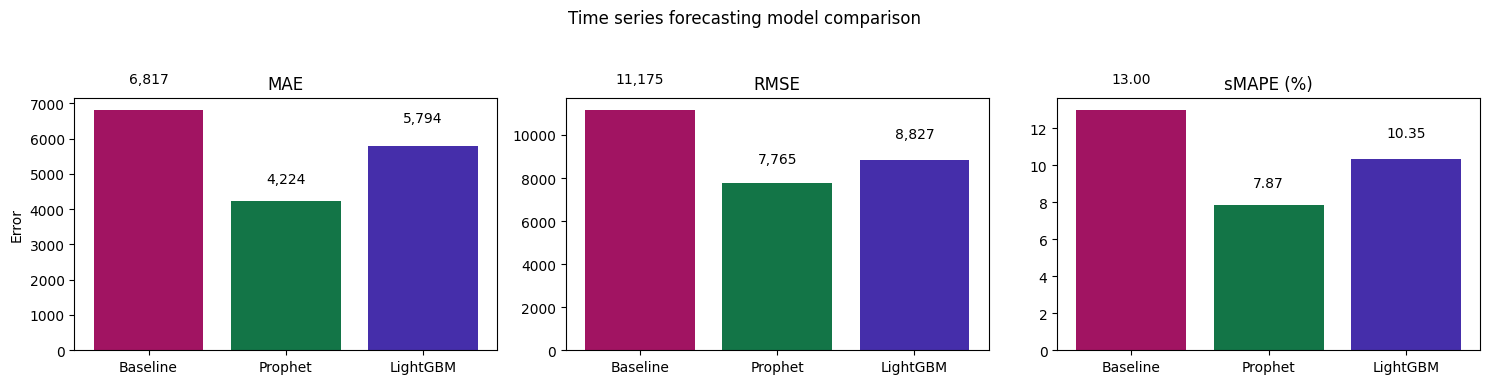

In [57]:
# Compare MAE, RMSE and sMAPE for the three approaches
models = ["Baseline", "Prophet", "LightGBM"]

mae_vals = [baseline_mae, prophet_mae, lightgbm_mae]
rmse_vals = [baseline_rmse, prophet_rmse, lightgbm_rmse]
smape_vals = [baseline_smape, prophet_smape, lightgbm_smape]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].bar(models, mae_vals, color=colors)
axes[0].set_title("MAE")
axes[0].set_ylabel("Error")
for i, v in enumerate(mae_vals):
    axes[0].text(i, v * 1.1, f"{v:,.0f}", ha="center", va="bottom")

axes[1].bar(models, rmse_vals, color=colors)
axes[1].set_title("RMSE")
for i, v in enumerate(rmse_vals):
    axes[1].text(i, v * 1.1, f"{v:,.0f}", ha="center", va="bottom")

axes[2].bar(models, smape_vals, color=colors)
axes[2].set_title("sMAPE (%)")
for i, v in enumerate(smape_vals):
    axes[2].text(i, v * 1.1, f"{v:.2f}", ha="center", va="bottom")

plt.suptitle("Time series forecasting model comparison")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Verdict
Prophet outperforms LightGBM.